# Implementing and Training ConvCNPs for Hydrology

### Import required packages

In [1]:
%load_ext autoreload
%autoreload 2

import config as C

from IPython import display

import os
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import pandas as pd
import pdb
import torch
import torch.nn as nn
import pickle

import scipy.stats

# from sklearn import preprocessing
# from scipy.special import inv_boxcox
# from scipy.stats import boxcox
import stheno.torch as stheno

#import convcnp.data
# import convcnp.data_hydro_2
import data_hydro_2_extended
# import convcnp.data_365
# import convcnp.data_loader_pytorch
import NSE
# from metrics import *
#import convcnp.task_preprocessing as tp

from experiment import report_loss, RunningAverage, save_checkpoint
from utils import gaussian_logpdf, gamma_logpdf, init_sequential_weights, to_multiple, to_numpy, gamma_stats
from plot_utils import *
from architectures import SimpleConv, UNet, SeparableConv1d, Conv1d, DepthSepConv1d
from convcnp_architectures import DeepSet, ConvDeepSet, FinalLayer, ConvCNP
from task_utils import task_to_device, loaded_task, try_to_delete

from numpy import loadtxt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformations import rev_transform, rev_transform_tensor, scaling, standardise, log_transform, boxcox_transform

from plot_utils import plot_model_task

from experiment import WorkingDirectory, generate_root

from data_loader_pytorch import *

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(device)

c:\Users\Sior AMD-4\anaconda3\envs\hydro-nps\Lib\site-packages\fdm\fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
c:\Users\Sior AMD-4\anaconda3\envs\hydro-nps\Lib\site-packages\fdm\fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
c:\Users\Sior AMD-4\anaconda3\envs\hydro-nps\Lib\site-packages\fdm\fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
c:\Users\Sior AMD-4\anaconda3\envs\hydro-nps\Lib\site-packages\fdm\fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library 

cuda


In [2]:
torch.multiprocessing.set_start_method('spawn')  # Set the start method

### Import data

In [3]:
%%time
# df_raw = pd.read_csv(C.filepath)
df_raw = pd.read_pickle('df_raw.pkl')

CPU times: total: 2.27 s
Wall time: 2.94 s


In [4]:
selected_basins = loadtxt(C.basins_file, comments="#", delimiter=",", unpack=False, dtype="int")

In [5]:
%%time

df_raw = df_raw[df_raw['basin'].isin(selected_basins)]
print("Length of dataframe for selected basin: ", len(df_raw))

df_raw.drop(['MOD_RUN'],axis=1,inplace=True)

df_raw.drop_duplicates(inplace=True)
print("Length of dataframe after dropping duplicates: ", len(df_raw))

df_raw = df_raw[df_raw['OBS_RUN']>=0]
print("Length of dataframe after filtering out error values: ", len(df_raw))

df_raw['year'] = df_raw['YR']

Length of dataframe for selected basin:  6521041
Length of dataframe after dropping duplicates:  6520841
Length of dataframe after filtering out error values:  6518953
CPU times: total: 14.6 s
Wall time: 17 s


### Catchment Attributes

In [6]:
df_att = pd.read_csv(C.path)
numeric_attributes = df_att.select_dtypes('float64').columns.tolist()

for att in numeric_attributes:
    df_att[att] = standardise(df_att[att])

#df_att_n['hru08'] = df_att['hru08']
#df_att.describe()

In [7]:
df = df_raw.copy() 

In [8]:
dist='gaussian'

log_transformation = False
boxcox_transformation = False

if log_transformation == 'log':

    target_fields = [#'OBS_RUN',
                    'prcp(mm/day)']

    for f in target_fields:
        df[f] = log_transform(df_raw[f], 1)
        print(f"log of {f}")

if boxcox_transformation == 'boxcox':

    target_fields = ['prcp(mm/day)']
    
    for f in target_fields:
        df[f], lambda_val = boxcox_transform(df_raw[f], 1e-6)
        
        # replace special characters in lambda_val
        for ch in ['(',')','/']:
            f = f.replace(ch,"_") 
        
        exec("lambda_" + f + " = " + str(lambda_val)) # save lambda value to a variable
        print("lambda_" + f + " = ", lambda_val)


In [9]:
df, q_mu, q_sigma = scaling(df, C.fields, method='std')

In [10]:
if dist=='gamma':
    Q_shift = abs(df['OBS_RUN'].min()) + 1
    df['OBS_RUN'] = df['OBS_RUN'] + Q_shift
    print(f'Shifted by {Q_shift}')
else:
    print('No shift')

No shift


### Load dict

In [11]:
# a_file = open("train_test_splits/k5fold_split.pkl", "rb")
# k5fold_dict = pickle.load(a_file)

## Train test sets

In [12]:
tr = te = selected_basins

In [13]:
# tr = k5fold_dict['train_basins_01']
# te = k5fold_dict['test_basins_01']

print(f'Train test split random: {len(tr)} train and {len(te)} test locations')

Train test split random: 531 train and 531 test locations


In [14]:
df['OBS_RUN_mean'] = df.groupby('hru08')['OBS_RUN'].transform(lambda x: x.mean())

df_train = df[(df['DATE'] >= C.s_date_tr) & (df['DATE'] <= C.e_date_tr) & (df['basin'].isin(tr))].copy()
df_test_both = df[(df['DATE'] >= C.s_date_te) & (df['DATE'] <= C.e_date_te) & (df['basin'].isin(te))].copy()
df_test_catchment = df[(df['DATE'] >= C.s_date_tr) & (df['DATE'] <= C.e_date_tr) & (df['basin'].isin(te))].copy()
df_test_temporal = df[(df['DATE'] >= C.s_date_te) & (df['DATE'] <= C.e_date_te) & (df['basin'].isin(tr))].copy()

df_train.drop(C.list_to_drop,axis=1,inplace=True)
df_test_both.drop(C.list_to_drop,axis=1,inplace=True)
df_test_catchment.drop(C.list_to_drop,axis=1,inplace=True)
df_test_temporal.drop(C.list_to_drop,axis=1,inplace=True)

df_train.reset_index(drop=True,inplace=True)
df_test_temporal.reset_index(drop=True,inplace=True)
df_test_catchment.reset_index(drop=True,inplace=True)
df_test_both.reset_index(drop=True,inplace=True)

## Model

In [15]:
# Instantiate ConvCNP
model = ConvCNP(in_channels = len(C.context_channels),
                #rho=SimpleConv(),
                rho=UNet(),
                #rho=DepthSepConv1d(in_channels=rho_in_channels, conv_channels=64, num_layers=7, kernel_size=15),
                points_per_unit=64*8,
                dynamic_embedding_dims=C.dynamic_embedding_dims,
                static_embedding_dims=C.static_embedding_dims,
                static_feature_embedding=C.static_feature_embedding,
                static_embedding_in_channels=C.static_embedding_in_channels,
                static_feature_missing_data=C.static_feature_missing_data,
                static_embedding_location=C.static_embedding_location,
                distribution=dist)

# Assign model to device
model.to(device)

print(model.num_params)

51413


In [16]:
# from new_data import create_dataloader, HydroGeneratore

# # Usage example:
# dataloader = create_dataloader(dataframe=df_train, 
#                                df_att=df_att, 
#                                channels_c=C.context_channels, 
#                                channels_t=C.target_channels, 
#                                channels_att=C.attributes, 
#                                batch_size=32)

# generator = HydroGeneratore(dataloader, device)

# for task in generator.generate_tasks():
#     break

In [17]:
# for i in range(8):
#     x = task['x'][0,:].cpu()
#     y1 = task['y_context'][0,i,:].cpu()
#     y2 = task['y_target'][0,i,:].cpu()

#     plt.plot(x,y1,'o', label=f'y1{i}')
#     # plt.plot(x,y2,'o', label=f'y2{i}')

# plt.legend()
# plt.show()

## Training Data Generation

In [19]:
gen = data_hydro_2_extended.HydroGenerator(
                                            dataframe = df_train,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = 16,
                                            channels_c = C.context_channels,
                                            channels_t = C.target_channels,
                                            channels_att = C.attributes,
                                            channels_t_val = C.target_val_channel,
                                            context_mask = C.context_mask,
                                            target_mask = C.target_mask,
                                            extrapolate = C.extrapolate_flag,
                                            timeslice = C.timeslice,
                                            dropout_rate = 0, #  0.3,
                                            concat_static_features = C.concat_static_features,
                                            min_train_points= C.min_train_points,
                                            min_test_points= C.min_test_points,
                                            max_train_points= C.max_train_points,
                                            max_test_points= C.max_test_points,
                                            device='cpu',
                                            )

# task = gen.generate_task()
# fig = plt.figure(figsize=(24, 5))
# for i in range(3):
#     plt.subplot(1, 3, i + 1)
#     plot_task(task, i, legend=i==2)
# plt.show()

## Training Methods

With our model in place, let's next define a training procedure. The `train` function below performs one training epoch (as defined by the number of tasks in an epoch from our data generator) as follows:
1. Iterate over the tasks in the epoch
2. For every task, condition on the context set, and make (Gaussian) predictions at the target locations.
3. Compute the log-likelihood of the predictions under the target set.
4. Backpropagate the error from the (negative) log-likelihood to the model parameters 

The `RunningAverage` average object will maintain a running average of the negative log-likelihood. In addition, we provide a plotting function so as to visually monitor the progress of the training procedure.

In [20]:
def train(data, model, opt, dist='gaussian', ):
    #Perform a training epoch.
    ravg = RunningAverage()
    ravg_nse = RunningAverage() 
    model.train()
    task_obj_list = []
    
    for step, task in enumerate(data):
        
        task = loaded_task(task)
        
        y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], 
                               task['feature'], task['m'], 
                               static_masking_rate=static_masking_rate, 
                               embedding=C.feature_embedding_flag)
        
        if dist == 'gaussian':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gamma':
            y_mean, y_std = gamma_stats(y_loc, y_scale)
            obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gaussian_fixed':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale/y_scale, 'batched_mean')
        
        obj.backward()
        opt.step()
        opt.zero_grad()
              
        obj_nse = NSE.nse_tensor(obs = rev_transform_tensor(task['y_target']),
                                 mean_obs = rev_transform_tensor(task['y_target_val']),
                                 sim = rev_transform_tensor(y_mean))
        
        task_obj_list.append(obj.item())
        ravg.update(obj.item(), data.batch_size)
        ravg_nse.update(obj_nse.item(), data.batch_size)
        
        if step % 25 == 0:
            print("step %s -- avg training loss is %.3f" % (step, ravg.avg)) 
            
    plt.plot(task_obj_list)
    plt.show
        
    return ravg.avg, ravg_nse.avg

In [21]:
# Create a fixed set of outputs to predict at when plotting.
x_test = torch.linspace(0., 1.,C.timeslice)[None, :, None].to(device)

In [22]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 16 # 128
gen_test = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_both,
                                            df_att = df_att,
                                            batch_size = 32,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = C.context_channels,
                                            channels_t = C.target_channels,
                                            channels_att = C.attributes,
                                            channels_t_val = C.target_val_channel,
                                            context_mask = C.context_mask,
                                            target_mask = C.target_mask,
                                            extrapolate = False,
                                            concat_static_features = C.concat_static_features,
                                            timeslice = C.timeslice,
                                            min_train_points = C.min_train_points,
                                            min_test_points = C.min_test_points,
                                            max_train_points = C.max_train_points,
                                            max_test_points = C.max_test_points,
                                            device = 'cpu'
                                            )

# task = gen_test.generate_task()
# fig = plt.figure(figsize=(24, 5))
# for i in range(3):
#     plt.subplot(1, 3, i + 1)
#     plot_task(task, i, legend=i==2)
# plt.show()

In [23]:
# Instantiate data generator for validation.
NUM_TEST_TASKS = 16 # 128
gen_val = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_catchment,
                                            df_att = df_att,
                                            batch_size = 32,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = C.context_channels,
                                            channels_t = C.target_channels,
                                            channels_att = C.attributes,
                                            channels_t_val = C.target_val_channel,
                                            context_mask = C.context_mask,
                                            target_mask = C.target_mask,
                                            extrapolate = False,
                                            concat_static_features = C.concat_static_features,
                                            timeslice = C.timeslice,
                                            min_train_points = C.min_train_points,
                                            min_test_points = C.min_test_points,
                                            max_train_points = C.max_train_points,
                                            max_test_points = C.max_test_points,
                                            device = 'cpu'
                                            )

# task = gen_val.generate_task()
# fig = plt.figure(figsize=(24, 5))
# for i in range(3):
#     plt.subplot(1, 3, i + 1)
#     plot_task(task, i, legend=i==2)
# plt.show()

In [24]:
def get_batch_size(x):
    if x.__class__ == 'torch.utils.data.dataloader.DataLoader':
        return x.dataset.gen.batch_size
    else:
        return x.batch_size

In [25]:
def test(gen_test,model,dist='gaussian',fig_flag=False):
    # Compute average task log-likelihood.
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    
    model.eval()
    start = time.time()
    
    with torch.no_grad():
        for _, task in enumerate(gen_test):
            # torch.cuda.empty_cache()
            task = loaded_task(task)
            y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], 
                                   task['feature'], task['m'], 
                                   static_masking_rate = static_masking_rate,
                                   embedding=C.feature_embedding_flag)        
            if dist == 'gaussian':
                y_mean, y_std = y_loc, y_scale
                obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            elif dist == 'gamma':
                y_mean, y_std = gamma_stats(y_loc, y_scale)
                obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            if dist == 'gaussian_fixed':
                y_mean, y_std = y_loc, y_scale
                obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale/y_scale, 'batched_mean')
            
            batch_size = get_batch_size(gen_test)
            
            obj_nse = NSE.nse_tensor(obs=rev_transform_tensor(task['y_target'],mu=q_mu,sigma=q_sigma, scaling='STANRDARD'),
                                     mean_obs=rev_transform_tensor(task['y_target_val'],mu=q_mu,sigma=q_sigma, scaling='STANRDARD'),
                                     sim=rev_transform_tensor(y_mean,mu=q_mu,sigma=q_sigma, scaling='STANRDARD'))       
            
            ravg.update(obj.item(), batch_size)
            #print(batch_size)
            ravg_nse.update(obj_nse.item(), batch_size)

    if fig_flag:
        fig = plt.figure(figsize=(24, 15))
        for i in range(3):
            plt.subplot(3, 1, i + 1)
            plot_model_task(model, task, C.timeslice, idx=i, legend=i==2, dist=dist)
        plt.show()

        elapsed = time.time() - start        
        print('Test NLL: %.3f -- NSE: %.3f -- time: %.3f' % (ravg.avg, ravg_nse.avg, elapsed))
    
    return ravg.avg


## Training loop for the model

Now we can write a standard PyTorch optimization loop. First, we instantiate an optimizer (here we use an Adam optimizer). Then, we simply iterate for as many epochs as necessary to train the model. Every so often we will print the training error (since the data are generated on the fly, this is also a reasonable estimator for the held out error), and produce a plot demonstrating the model performance. Note that the next block of code will train the model for 100 epochs. This may take some time, and it is highly recommended to do so with a GPU!

In [26]:
change_folder = True

if change_folder:
    experiment_name = 'test_Unet'
    wd = WorkingDirectory(generate_root(experiment_name))

Root: _experiments\2024-05-12_22-51-59_test-unet


In [27]:
load_model = False
load_dict = False

load_root = '_experiments/2020-08-01_22-10-37_k5fold-01-gamma-staticfs-after-encoder-unet'

if load_model:
    PATH = f'{load_root}/model_best.pth.tar'
    #PATH = f'{load_root}/e_61_loss_151.753.pth.tar'
    model.load_state_dict(torch.load(PATH))
    
if load_dict:
    a_file = open(os.path.join(load_root,"loss_dict.pkl"), "rb")
    loss_dict = pickle.load(a_file)
    a_file.close()
    
    epoch_list = loss_dict['epochs']
    train_obj_list = loss_dict['training_loss'] 
    train_nse_list = loss_dict['training_nse'] 
    test_obj_list = loss_dict['test_loss'] 

In [28]:
reset_epochs = True

if reset_epochs:
    train_obj_list, train_nse_list, test_obj_list, epoch_list = [], [], [], []

In [29]:
# torch.cuda.empty_cache()
try_to_delete(['task','minitask'])

task does not exist
minitask does not exist


In [30]:
gen.batch_size = 32
gen_val.batch_size = 32
gen_test.batch_size = 32

gen.num_tasks = 128
gen_val.num_tasks = 64
gen_test.num_tasks = 64

gen.dropout_rate = 0
gen_val.dropout_rate = 0
gen_test.dropout_rate = 0
static_masking_rate = 0

# train_dataloader = DataLoader(dataset=HydroDataset(gen,num_tasks_epoch=128), batch_size=1, num_workers=16, shuffle=True, pin_memory=True)
# test_dataloader = DataLoader(dataset=HydroDataset(gen_test,num_tasks_epoch=64), batch_size=1, num_workers=16, shuffle=False, pin_memory=True)
# val_dataloader = DataLoader(dataset=HydroDataset(gen_val,num_tasks_epoch=64), batch_size=1, num_workers=16, shuffle=False, pin_memory=True)

In [31]:
load_best = False
if load_best:
    model.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))

In [32]:
dist = "gaussian"

In [ ]:
# torch.autograd.set_detect_anomaly(False)

# Some training hyper-parameters:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
PLOT_FREQ = 1

plot_model = False

if len(epoch_list)>0:
    last_epoch = epoch_list[-1]
else:
    last_epoch = 0

# Initialize optimizer
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Run the training loop.
for epoch in range(NUM_EPOCHS):
    # Compute training objective.
    start_time = time.time()
    train_obj, train_nse = train(gen, model, opt, dist=dist)

    epoch_list.append(epoch+last_epoch)
    train_obj_list.append(train_obj)
    train_nse_list.append(train_nse)
    
    #torch.cuda.empty_cache()
    test_obj = test(gen_test,model,dist=dist)
    #torch.cuda.empty_cache()
    test_obj_list.append(test_obj)
    
    elapsed = time.time() - start_time
    
    # Plot model behaviour every now and again.
    if (epoch % PLOT_FREQ == 0) and plot_model:
        
        task = task_to_device(gen_val.generate_task())
        fig = plt.figure(figsize=(24, 5))
        
        for i in range(1):
            plt.subplot(1, 1, i + 1)
            plot_model_task(model, task, timeslice=C.timeslice, idx=i, legend=i==2, dist=dist)
        
        plt.title('Test set')
        display.clear_output(wait=True)


    print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch + last_epoch, train_obj, test_obj, train_nse, elapsed))

    plot_training_loss(train_obj_list, test_obj_list)
    plt.show()
    
    save_as_best = True if test_obj == min(test_obj_list) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch + last_epoch, test_obj))
    torch.save(model.state_dict(), PATH)

In [38]:
save_dict = True

if save_dict:
    model_hyperparams={}
    model_hyperparams['lr'] = LEARNING_RATE
    model_hyperparams['distribution'] = dist
    model_hyperparams['train_batch_size'] = gen.batch_size
    #model_hyperparams['batches_per_epoch'] = gen.num_tasks_epoch
    model_hyperparams['static_masking_rate'] = C.static_masking_rate
    model_hyperparams['dynamic masking rate'] = gen.dropout_rate
    model_hyperparams['static_embedding_dims'] = C.static_embedding_dims
    model_hyperparams['dynamic_embedding_dims'] = C.dynamic_embedding_dims

    a_file = open(os.path.join(wd.root,"model_hyperparams.pkl"), "wb")
    pickle.dump(model_hyperparams, a_file)
    a_file.close()
    print('Saved successfuly')


Saved successfuly


In [39]:
save_dict = True

if save_dict:
    loss_dict={}
    loss_dict['epochs'] = epoch_list
    loss_dict['training_loss'] = train_obj_list
    loss_dict['training_nse'] = train_nse_list
    loss_dict['test_loss'] = test_obj_list

    a_file = open(os.path.join(wd.root,"loss_dict.pkl"), "wb")
    pickle.dump(loss_dict, a_file)
    a_file.close()
    print('Saved successfuly')
    

Saved successfuly


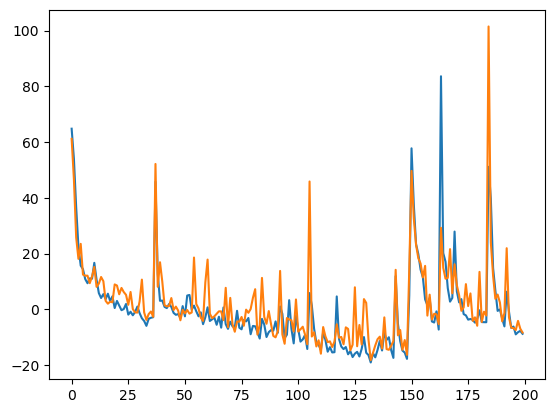

In [40]:
plt.plot(train_obj_list)
plt.plot(test_obj_list)
#plt.ylim([-100,100])
plt.show()

## Test model

In [42]:
ROOT_PATH = r'_experiments\2024-05-12_22-51-59_test-unet'
model.load_state_dict(torch.load(os.path.join(ROOT_PATH, 'model_best.pth.tar')))

<All keys matched successfully>

In [43]:
# torch.cuda.empty_cache()
# try_to_delete(['task'])

task does not exist


In [44]:
# x = i['x'][0,0,:,0]
# xt = i['x_target'][0,0,:,0]
# y = rev_transform_tensor(i['y'][0,0,:,0],mu=q_mu,sigma=q_sigma, scaling='STANRDARD')
# yt = rev_transform_tensor(i['y_target'][0,0,:,0],mu=q_mu,sigma=q_sigma, scaling='STANRDARD')
# y_mean = rev_transform_tensor(i['y_target_val'][0,0,:,0],mu=q_mu,sigma=q_sigma, scaling='STANRDARD')
# plt.plot(x,y,'o',label='1')
# plt.plot(xt,y_mean,'.',label='2')
# plt.plot([0,1],[y.mean(),y.mean()],label='3')
# plt.plot([0,1],[yt.mean(),yt.mean()],label='4')
# plt.legend()
# plt.show()


NameError: name 'y_mean_NSE' is not defined

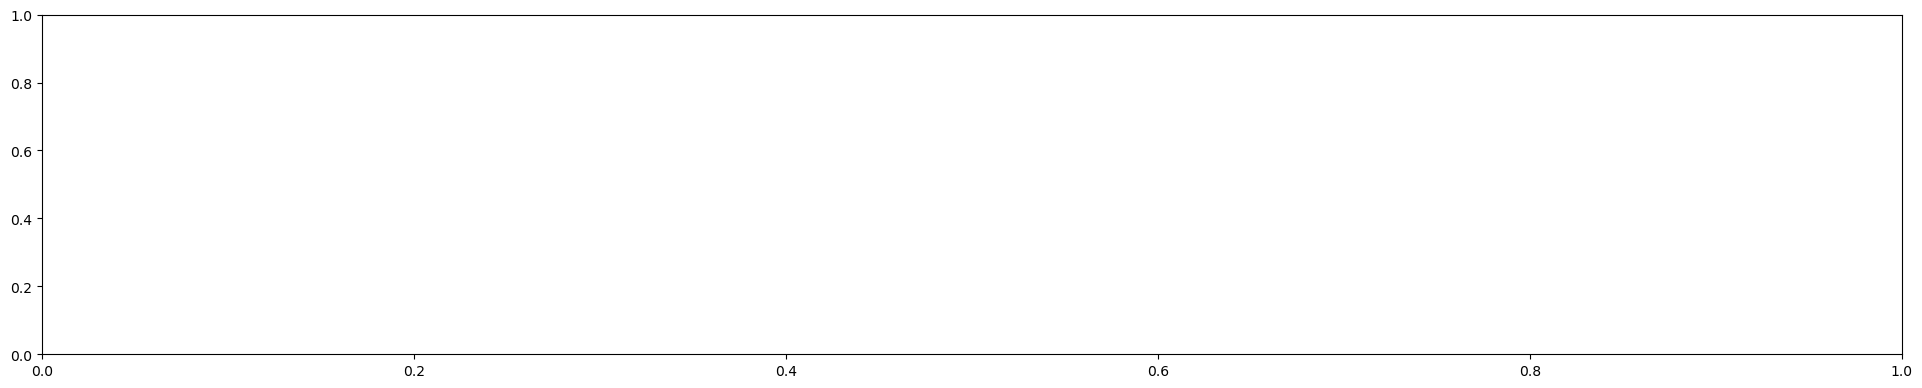

In [45]:
gen_for_test = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_both,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = 32,
                                            channels_c = C.context_channels,
                                            channels_t = C.target_channels,
                                            channels_att = C.attributes,
                                            channels_t_val = C.target_val_channel,
                                            context_mask = C.context_mask,
                                            target_mask = C.target_mask,
                                            extrapolate = True,
                                            timeslice = C.timeslice,
                                            dropout_rate = 0,
                                            concat_static_features = False,
                                            min_train_points = 90,
                                            min_test_points = 1,
                                            max_train_points = 91,
                                            max_test_points = 1,
                                            device='cpu',
                                            )
        

# tester = DataLoader(dataset=HydroDataset(gen_for_test,num_tasks_epoch=1), batch_size=1, shuffle=False, num_workers=1, pin_memory=False)
test(gen_for_test,model,dist=dist,fig_flag=True)

## Evaluation 

We can also evaluate the trained model to get better estimates of its performance. To do so, we will first introduce an additional data generator that will generate far more tasks for us. Then, we will loop over many tasks, and compute (and print) the average log-likelihood.

In [ ]:
"""%%capture
#load model
##model = TheModelClass(*args, **kwargs)
PATH = '../../saved_models/model_022.pt'
model.load_state_dict(torch.load(PATH))
model.eval()"""

In [ ]:
"""model_number = 23
save_model_name = f'model_{model_number}_{dist}_static-features_{static_embedding_location}_{s_date_tr}_to_{e_date_tr}'
save_model_name"""

In [ ]:
"""PATH = r'..\..\saved_models\model_022.pt'
torch.save(model.state_dict(),PATH)"""

In [57]:
ROOT_PATH = r'_experiments\2024-05-12_22-51-59_test-unet\e_132_loss_-18.188.pth.tar'
#PATH = f'{ROOT_PATH}/model_best.pth.tar'
model.load_state_dict(torch.load(ROOT_PATH))

<All keys matched successfully>

## Test NSE performance at 365/1-day ahead task

In [59]:
# from metrics import *
# import scipy.stats
df_test = df_test_temporal

In [53]:
# var_list = ['minitask','task']
# try_to_delete(var_list)

In [112]:
task_1 = gen_365.generate_test_task(year=1996, basin='hru_01022500')

In [ ]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 10
gen_365 = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = C.context_channels,
                                            channels_t = C.target_channels,
                                            channels_att = C.attributes,
                                            channels_t_val = C.target_val_channel,
                                            context_mask = C.context_mask,
                                            target_mask = C.target_mask,
                                            concat_static_features = C.concat_static_features,
                                            extrapolate = True,
                                            timeslice = 90,
                                            min_train_points=89,
                                            min_test_points=1,
                                            max_train_points=89,
                                            max_test_points=1,
                                            device='cpu')

out = np.array([])
out_2 = np.array([])

# Compute average task log-likelihood.
basins = df_test['hru08'].unique().tolist()
print(len(basins))
b=0
for basin in basins[:]:

    b+=1
    
    # ravg = RunningAverage()
    # ravg_nse = RunningAverage()
    # model.eval()
    # start = time.time()
    
    # pred_mu = np.array([])
    # pred_mu2 = np.array([])
    # pred_sigma = np.array([])
    # pred_loc = np.array([])
    # pred_scale = np.array([])
    # observations = np.array([])
    # DOY = np.array([])
    # YR = np.array([])
    # HRU = np.array([])
    
    # alpha_nse = np.array([])
    # beta_nse = np.array([])
    # nse_index = np.array([])
    # fhv = np.array([])
    # flv = np.array([])
    # fms = np.array([])
    
    obs_basin = np.array([])
    mean_obs_basin = np.array([])
    sim_basin = np.array([])

    with torch.no_grad():    
        years = df_test['YR'][df_test['hru08']==basin].unique().tolist()
        years = sorted(years)[1:]
        
        for year in years:

            if year != 2000:
                continue

            start = time.time()
            
            task = gen_365.generate_test_task(year=year, basin=basin)

            # elapsed = time.time() - start
            # print(f'Generator: {elapsed}')
            # start = time.time()

            task = loaded_task(task=task, device='cuda')

            y_mean, y_std = model(task['x_context'], task['y_context'], 
                                      task['x_target'],task['y_att'], 
                                      task['feature'],task['m'],
                                      static_masking_rate=0,
                                      embedding=C.feature_embedding_flag)
                                
            if dist == 'gaussian':
                obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
            elif dist == 'gaussian_fixed':
                obj = -gaussian_logpdf(task['y_target'], y_mean, y_std/y_std, 'batched_mean')
            elif dist == 'gamma':
                obj = -gamma_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
            
            #y_mu, y_sigma = rev_lognormal(to_numpy(y_mean), to_numpy(y_std))
            
            if dist == 'gamma':
                y_loc = y_mean
                y_scale = y_std
                g_mean = torch.distributions.gamma.Gamma(y_mean, y_std).mean
                g_var = torch.distributions.gamma.Gamma(y_mean, y_std).variance
                y_mean = g_mean
                y_std = torch.sqrt(g_var)

            obs = rev_transform(task['y_target'].flatten().cpu().numpy(), mu=q_mu, sigma=q_sigma)
            mean_obs = rev_transform(task['y_target_val'].flatten().cpu().numpy(), mu=q_mu, sigma=q_sigma)
            sim = rev_transform(y_mean.flatten().cpu().numpy(), mu=q_mu, sigma=q_sigma)

            obs_basin = np.concatenate((obs_basin,obs),axis=0)
            mean_obs_basin = np.concatenate((mean_obs_basin, mean_obs),axis=0)
            sim_basin = np.concatenate((sim_basin, sim), axis=0)

            # elapsed = time.time() - start
            # print(f'Model: {elapsed}')

            # print(year,basin)

            # plt.figure(figsize=(20,5))
            # plt.plot(obs,label='obs')
            # plt.plot(sim, label='sim')
            # plt.legend()
            # plt.show()

    try:
        nse = NSE.nse(obs=obs_basin
                ,mean_obs=mean_obs_basin
                ,sim=sim_basin)
        print(basin, nse)
    except:
        print(basin, "NSE can't be calculated")
        

In [62]:
importlib.reload(convcnp.transformations)
from convcnp.transformations import rev_lognormal

In [64]:
df_output = pd.DataFrame(out,columns=['HRU','YR','DOY','OBS_RUN','MOD_RUN_MU','MOD_RUN_SIGMA','PRED_LOC','PRED_SCALE'])
df_output_2 = pd.DataFrame(out_2, columns=['alpha_nse','beta_nse','nse_index','fhv','flv','fms'])

In [65]:
PATH = '_experiments/2020-08-02_00-31-53_k5fold-01-gamma-staticfs-after-encoder-unet'
df_output.to_csv(os.path.join(PATH,f'results_PGB_model_best_epoch_85.csv'),index=False)
df_output_2.to_csv(os.path.join(PATH,f'metrics_PGB_model_best_epoch_85.csv'),index=False)

In [66]:
"""df_output_test_both_40basins = df_output.copy()
df_output_test_both_40basins_2 = df_output_2.copy()"""

'df_output_test_both_40basins = df_output.copy()\ndf_output_test_both_40basins_2 = df_output_2.copy()'

424


/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= 

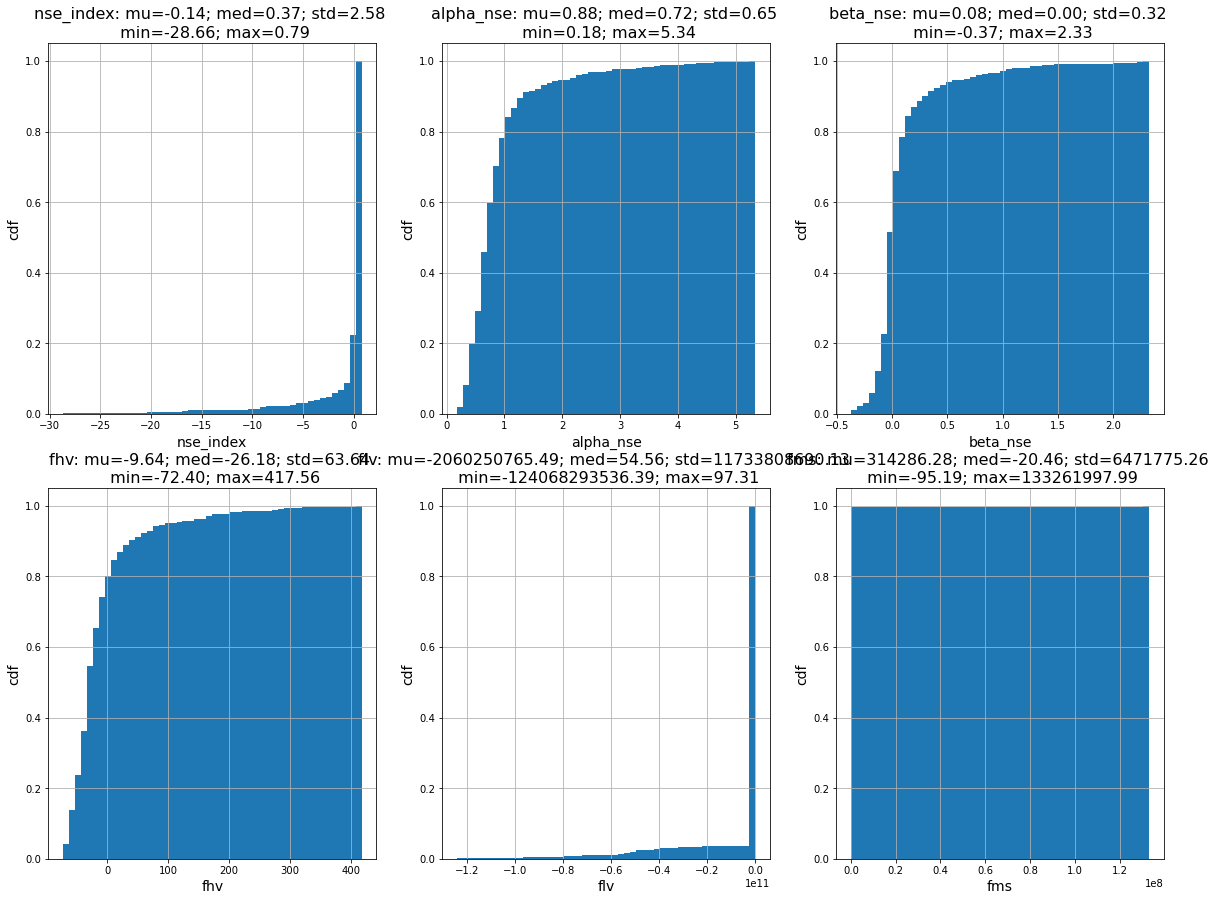

In [67]:
hrus = df_output['HRU'].unique()
nse_array = np.array([])
for hru in hrus:
    df_hru = df_output[df_output['HRU']==hru]
    obs = rev_transform(df_hru['OBS_RUN'].values.astype(np.float))
    mean_obs = np.ones(len(obs))*obs.mean()
    #print(mean_obs)
    mod = rev_transform(df_hru['MOD_RUN_MU'].values.astype(np.float))
    nse_array = np.append(nse_array, NSE.nse(obs,mean_obs,mod))

#print(f"Median NSE = {np.median(nse_array)}")
#print(f"Mean NSE = {nse_array.mean()}")
#print(f"NSE std = {nse_array.std()}")
print(len(nse_array))

list_metrics = ['nse_index','alpha_nse','beta_nse','fhv','flv','fms']

i = 0
fig = plt.figure(figsize=[20,15])
for m in list_metrics:
    i += 1
    plt.subplot(2,3,i)
    plt.hist(df_output_2[m], bins=50, density=True, 
         histtype='stepfilled',
         cumulative=True)
    plt.grid()
    
    plt.ylabel("cdf",fontsize = 14)
    plt.xlabel(m,fontsize=14)
    plt.title("%s: mu=%.2f; med=%.2f; std=%.2f \n min=%.2f; max=%.2f" % (m, df_output_2[m].mean(), df_output_2[m].median(), df_output_2[m].std(), df_output_2[m].min(), df_output_2[m].max()), fontsize=16)
    #plt.show()

In [68]:
df_output.columns

Index(['HRU', 'YR', 'DOY', 'OBS_RUN', 'MOD_RUN_MU', 'MOD_RUN_SIGMA',
       'PRED_LOC', 'PRED_SCALE'],
      dtype='object')

In [139]:
fig = plt.figure(figsize=[20,20])
for j in range(10):
    
    time_slice = 365
    x = np.arange(time_slice)
    hru_list = df_output['HRU'].unique()
    rand = np.random.randint(len(hru_list))
    hru_rand = hru_list[rand]

    i = np.random.randint(len(df_output['OBS_RUN'][df_output['HRU']==hru_rand])-time_slice)
    print(i)

    #fig = plt.figure(figsize=(24, 5))

    obs = df_output['OBS_RUN'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    pred_mu = df_output['MOD_RUN_MU'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    pred_sigma = df_output['MOD_RUN_SIGMA'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    doy = df_output['DOY'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)

    if dist=='gamma':
        pred_loc = df_output['PRED_LOC'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
        pred_scale = df_output['PRED_SCALE'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    
    plt.subplot(5,2,j+1)
    
    # Plot model predictions.
    plt.plot(x,obs, label='Observed', color='green')
    plt.plot(x,rev_transform(pred_mu), label='Model Output', color='blue')

    show_std = True

    if show_std:
        if dist=='gaussian':
            plt.fill_between(x,
                             rev_transform(pred_mu + 2 * pred_sigma),
                             rev_transform(pred_mu - 2 * pred_sigma),
                             color='tab:blue', alpha=0.2)

        elif dist=='gamma':
            p05 = rev_transform(scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale))
            p95 = rev_transform(scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale))
            p05[p05<0]=0
            #pdb.set_trace()
            plt.fill_between(x,
                            p05,
                            p95,
                            color='tab:blue', alpha=0.2)

    NSE = calc_nse(obs,rev_transform(pred_mu))
    plt.title("NSE = %.3f" % NSE, fontsize = 15)
    
    plt.xlim([0,time_slice])
    if (j+2)%2==0:
        plt.ylabel('Discharge (m3/s)', fontsize=15)
    plt.legend()
    plt.tight_layout()
    #plt.show()
    
SAVE_PATH  = '/home/donal/Documents/mg963/MResProject/figures'
plt.savefig(os.path.join(SAVE_PATH,('timeseries_gamma_PGB_%s.png' % (np.random.randint(100000)))), dpi=500, bbox_inches='tight') # 6

NameError: name 'df_output' is not defined

<Figure size 2000x2000 with 0 Axes>

## Test with known datanse_array

In [ ]:
import pickle
path = "test_tasks/generate_test_task_0.pkl"
a_file = open(path, "rb")
task = pickle.load(a_file)
a_file.close()

In [ ]:
import importlib
importlib.reload(convcnp.feature_mask)

In [ ]:
#import convcnp.feature_mask as mask
task = mask.task_mask(task, context_mask, target_mask)

In [ ]:
# Compute average task log-likelihood.
batch_size = task['x_context'].shape[0]
ravg = RunningAverage()
model.eval()
with torch.no_grad():
    y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'],task['f'],task['m'],embedding=C.feature_embedding_flag)
    obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        
    ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)
        
    fig = plt.figure(figsize=(24, 25))
    for i in range(5):
        plt.subplot(5, 1, i + 1)
        plot_model_task(model, task, idx=i, legend=i==2)
    plt.show()
    
elapsed = time.time() - start        
print('Model averages a log likelihood of %.3f on unseen tasks -- time: %.3f' % (-ravg.avg, elapsed))